In [59]:
######## Imports and definitions #########

import pandas as pd
import os
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R
import pickle
import numpy as np

sensor_list = ['TRK', 'RUA', 'RLA', 'RHA']
task_names = [
    'N-Pose Calibration',
    'Elbow Flexion Calibration',
    'Elbow Protation Calibration',
    'Wrist Flexion Calibration',
    'Wrist Deviation Calibration',
    'Shoulder Rotation Calibration',
    'Shoulder Flexion  Calibration',
    'Shoulder Abduction Calibration',
    'Scapula Elevation Calibration',
    'Scapula Protraction Calibration',
    'Elbow Flexion Task',
    'Elbow Pronation Task',
    'Shoulder Flexion Task',
    'Shoulder Abduction Task',
    'Shoulder Rotation Task',
    'Wrist Flexion Task',
    'Wrist Deviation Task',
    'Drinking Task',
    'Box Off Shelf Task',
    'Drawing Circles Task'  
]

with open('1.Raw_IMU_Data.pkl', 'rb') as f:
    data_dict = pickle.load(f)
    
    
def compute_qSI(nPose):
    
    # Python defines quaternions differently from matlab. The real part goes at the end of the quaterion
    qTRK = nPose['TRK'][['Quat_X', 'Quat_Y', 'Quat_Z', 'Quat_W']].mean().to_numpy() #Take the mean to have a single quaternion
    
    # print(qTRK)
    
    
    ## Define a body frame from the TRK sensor and compute qGB (global to body frame)
    rTRK = R.from_quat(qTRK).as_matrix() #Convert quaternion to rotation matrix
    
    xGB_temp = rTRK[:,2] #Take the z axis of the TRK sensor (third component)
    
    yGB = g = np.array([0,0,1])# Gravity vector
    zGB = np.cross(xGB_temp, yGB)/np.linalg.norm(np.cross(xGB_temp, yGB))
    xGB = np.cross(yGB, zGB)/np.linalg.norm(np.cross(yGB, zGB))
    
    GBc = R.from_matrix([xGB, yGB, zGB])
    qGBc = GBc.inv().as_quat()
    GBc = R.from_quat(qGBc)
    
    
    ## Compute qSI (sensor to inertial) for each sensor from qBI
    sensor_list = list(nPose.keys())
    sensor_list.remove('Task Name')
    SI = {}
    for i in range(len(sensor_list)):
        qGIc = nPose[sensor_list[i]][['Quat_X', 'Quat_Y', 'Quat_Z', 'Quat_W']].mean().to_numpy()
        GIc = R.from_quat(qGIc)
        # qSI[sensor_list[i]] = qGBc * qGI
        SI[sensor_list[i]] = GBc.inv() * GIc

    return SI


def compute_calibrated_quaternions(SI, Task):
    sensor_list = list(SI.keys())

    GS = {} # Global to segment

    for i in range(len(sensor_list)):
        SI_sensor = SI[sensor_list[i]]
        qGI_sensor = Task[sensor_list[i]][['Quat_X', 'Quat_Y', 'Quat_Z', 'Quat_W']].to_numpy()
        qGS_sensor = []
        for j in range(len(qGI_sensor)):
            GI_sensor_frame = R.from_quat(qGI_sensor[j,:])
            GS_sensor_frame = GI_sensor_frame * SI_sensor.inv()
            qGS_sensor.append(GS_sensor_frame.as_quat())
            
        GS[sensor_list[i]] = R.from_quat(np.asanyarray(qGS_sensor))
            
        
        
        # print(GI_sensor.as_quat())
        
        # GS[sensor_list[i]] = GI_sensor * SI_sensor.inv()
      
    return GS
        
        
def compute_joint_angles(GS):
    
    Joint_Angles = {}
    sensor_list = list(GS.keys())
    if ('TRK' in sensor_list) and ('RUA' in sensor_list):
        Joint_Angles['Right Shoulder'] = GS['TRK'].inv() * GS['RUA']
    
    if ('RUA' in sensor_list) and ('RLA' in sensor_list):
        Joint_Angles['Right Elbow'] = GS['RUA'].inv() * GS['RLA']   
        
    if ('RLA' in sensor_list) and ('RHA' in sensor_list):
        Joint_Angles['Right Wrist'] = GS['RLA'].inv() * GS['RHA']       
    
    return Joint_Angles
    

In [60]:
############# Identify the nPose Calibration and create a calibration quaterinion qSI for all segments #####

# For details on the computation of qSI see (Bonfiglio et al., 2024)
# Select calibration file and task files
Tasks = {}
nPose = data_dict[0]
SI = compute_qSI(nPose)

Joint_Angles_dict = {}
joint_angles_euler = {}
new_task_names = []
for i in range(10, len(data_dict)):
    
    joint_angles_euler[i-10] = {
        'Task Name': '',
        'Right Shoulder': [],
        'Right Elbow': [],
        'Right Wrist': []
    }
    
    current_task = data_dict[i]
    GS = compute_calibrated_quaternions(SI, current_task)    
    Joint_Angles_dict[i-10] = compute_joint_angles(GS)
    
    # Conver to Euler Angles
    if i == 13:
        sequence = 'XYZ'
    elif i == 15 or i == 16:
        sequence = 'ZYX'
    else:
        sequence = 'ZXY'
        
    right_shoulder = Joint_Angles_dict[i-10]['Right Shoulder'].as_euler(sequence)*180/np.pi
    right_elbow = Joint_Angles_dict[i-10]['Right Elbow'].as_euler(sequence)*180/np.pi
    right_wrist = Joint_Angles_dict[i-10]['Right Wrist'].as_euler(sequence)*180/np.pi
    
    #fix inconsistencies in joint angles
    if i == 13:
        right_shoulder[:,0] = -right_shoulder[:,0]
        
    if i == 14:
        right_shoulder = np.array([right_shoulder[:,0], right_shoulder[:,2], right_shoulder[:,1]]).transpose()
     
    right_elbow = np.array([right_elbow[:,0], right_elbow[:,2], right_elbow[:,1]]).transpose()    
    
    joint_angles_euler[i-10]['Task Name'] = task_names[i]
    joint_angles_euler[i-10]['Right Shoulder'] = right_shoulder
    joint_angles_euler[i-10]['Right Elbow'] = right_elbow
    joint_angles_euler[i-10]['Right Wrist'] = right_wrist
    

    
with open('2.IMU_Joint_Angles.pkl', 'wb') as f:
    pickle.dump(joint_angles_euler, f)

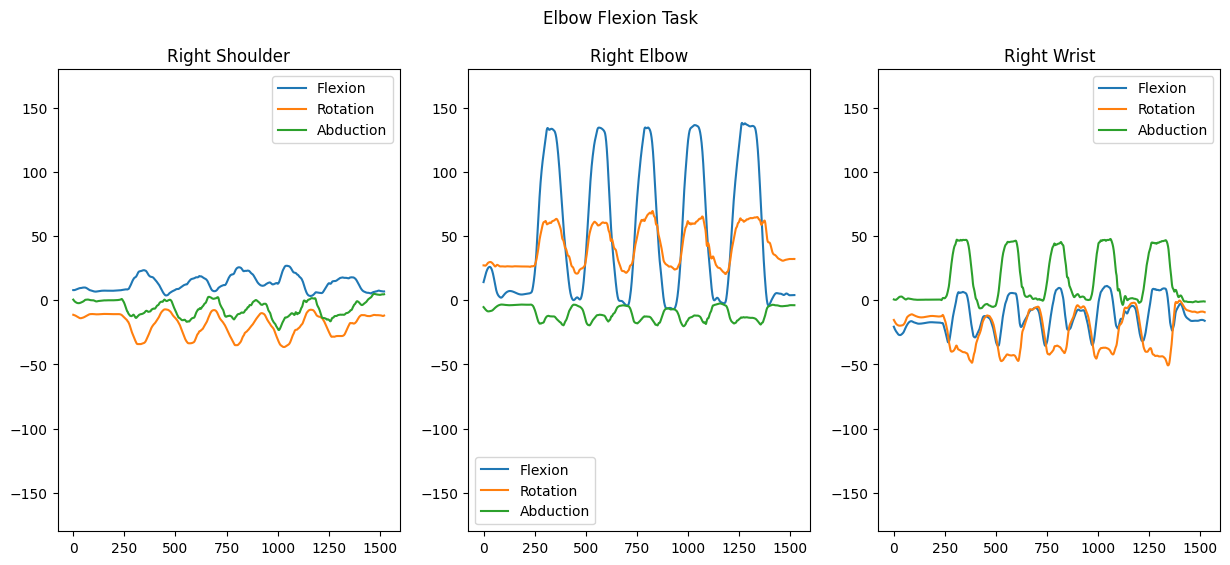

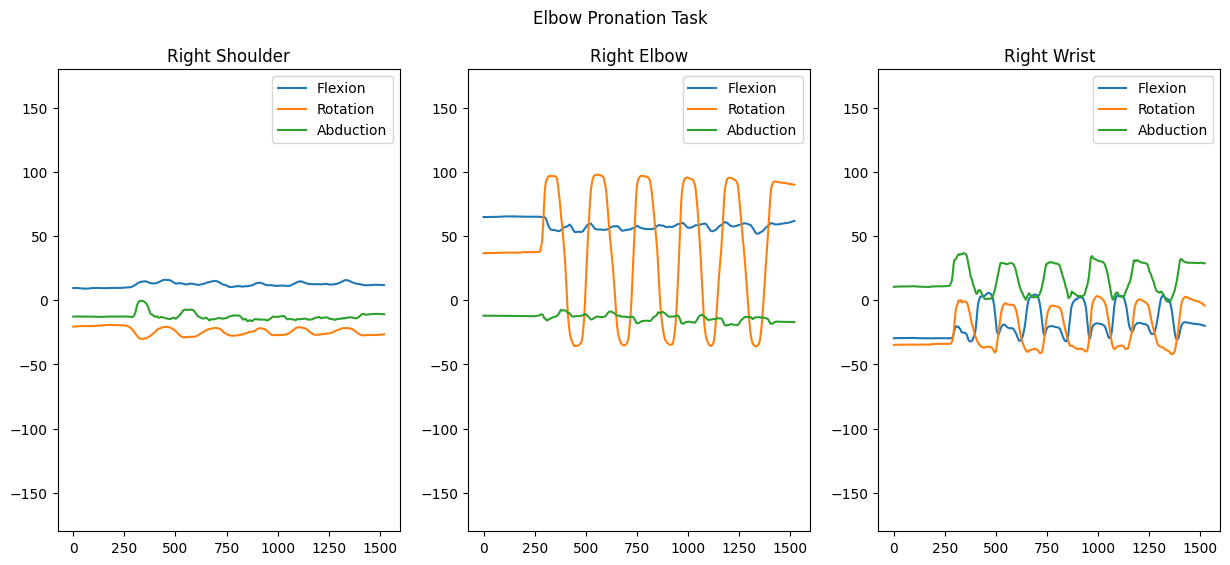

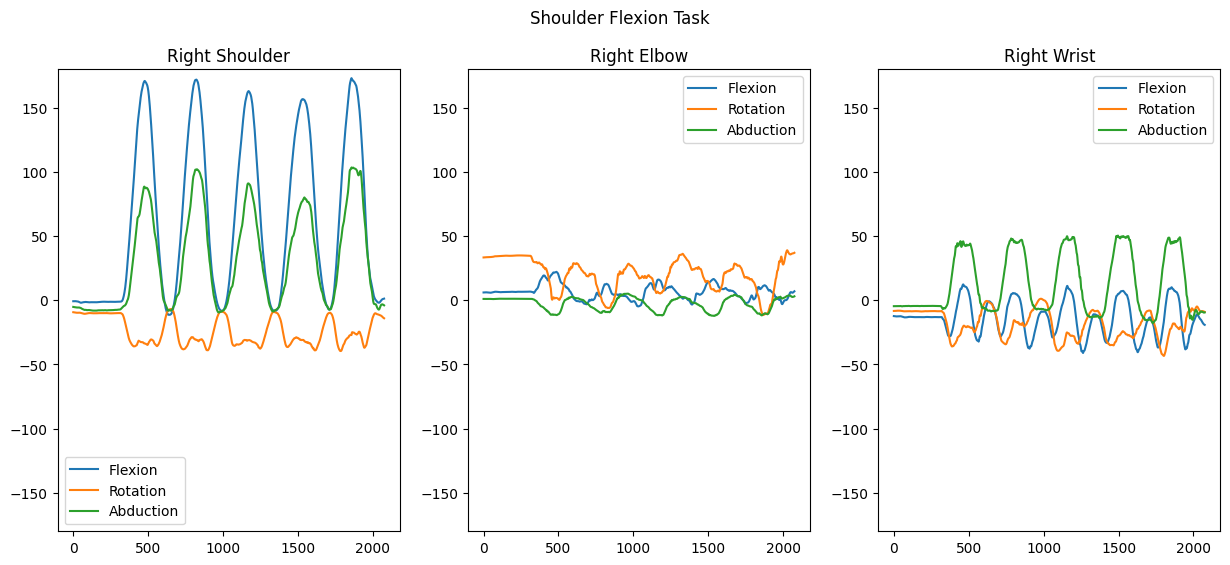

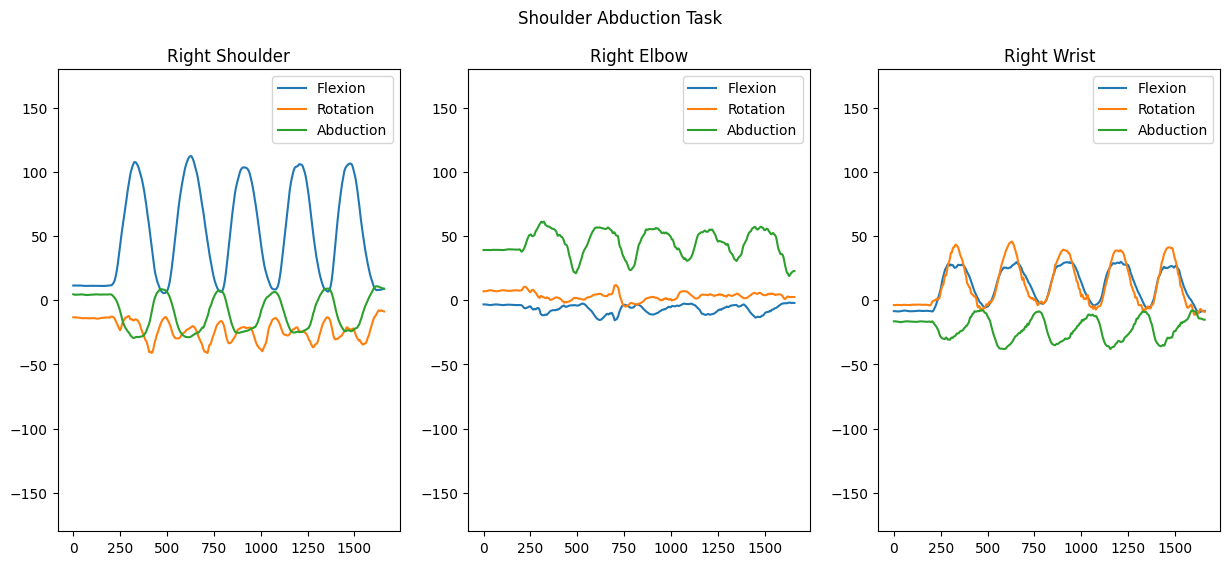

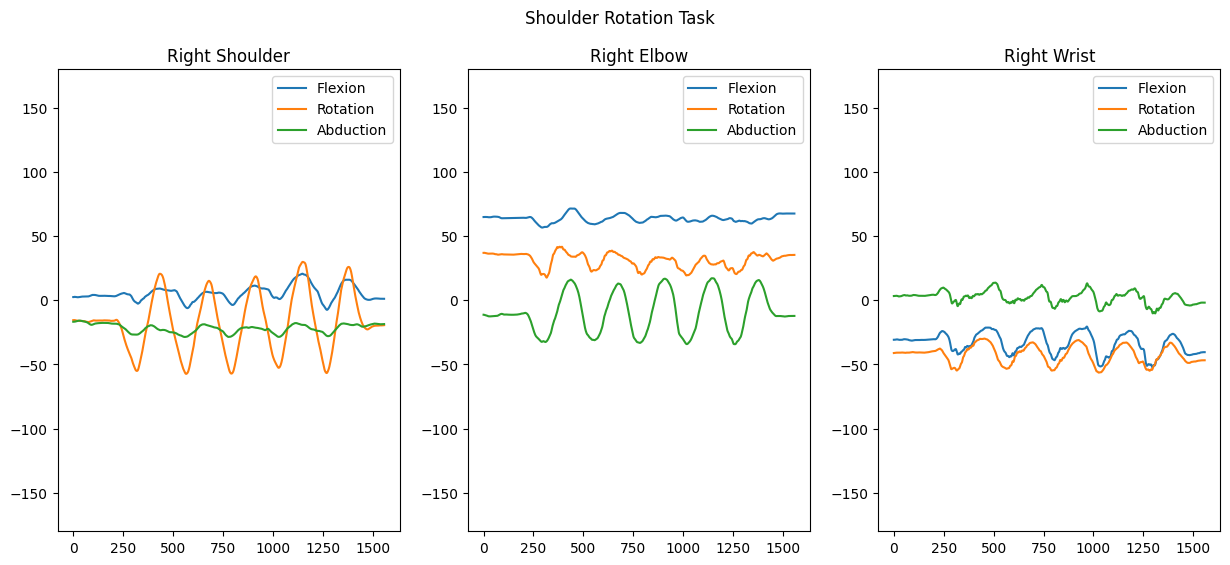

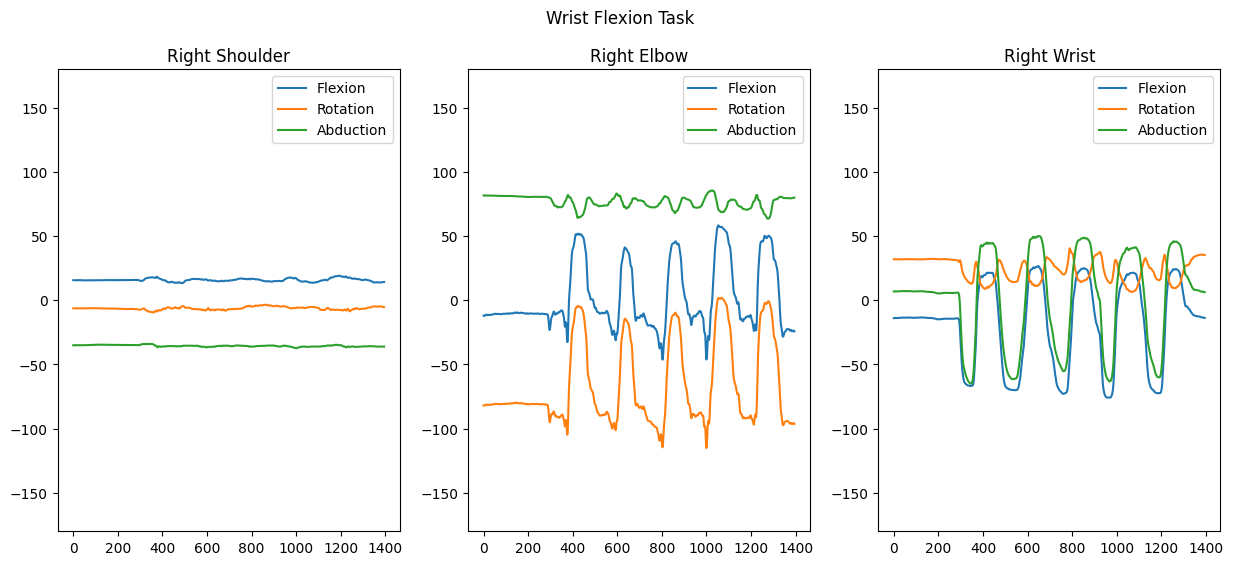

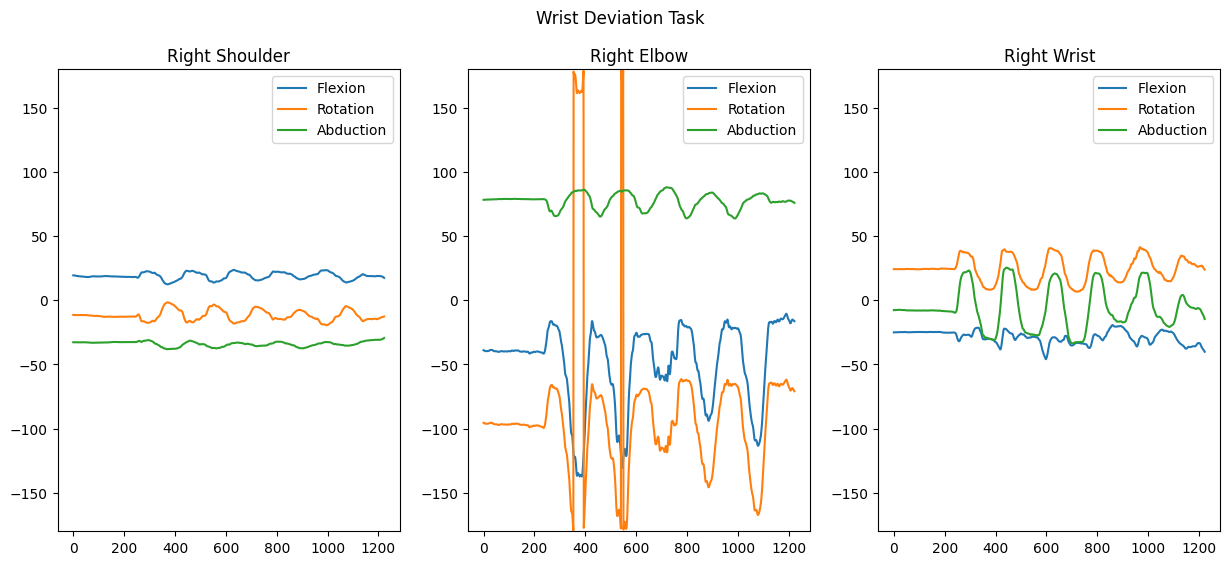

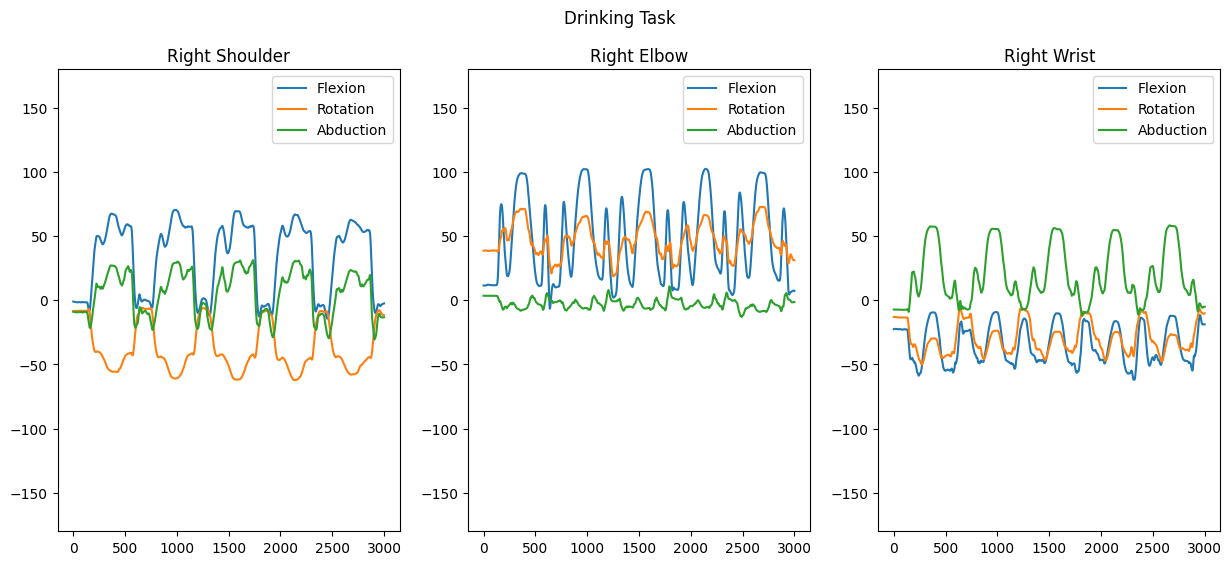

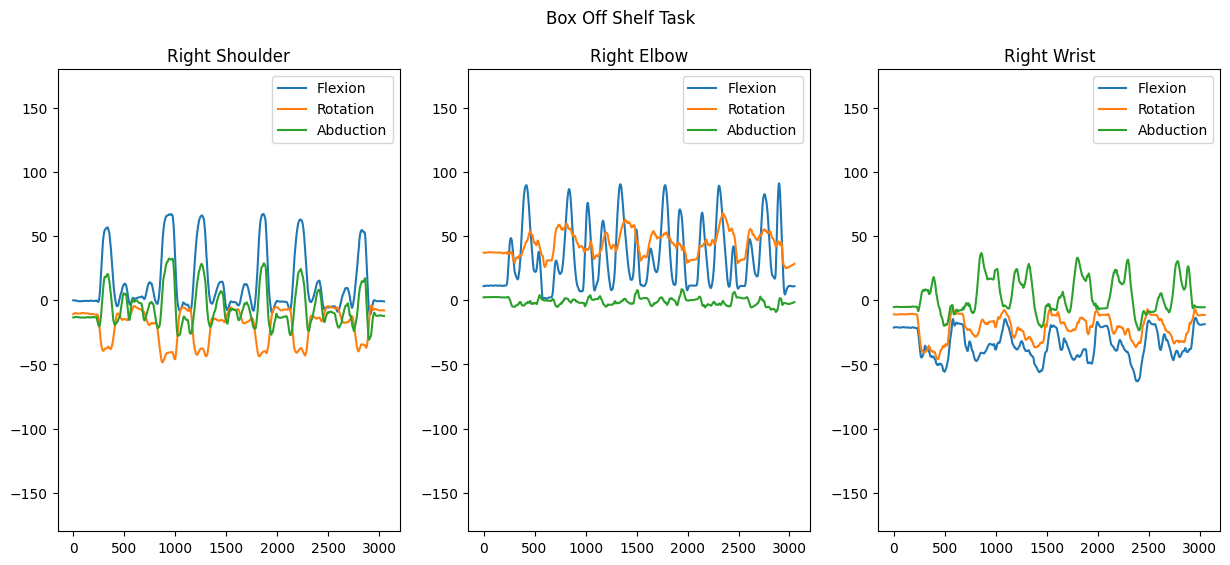

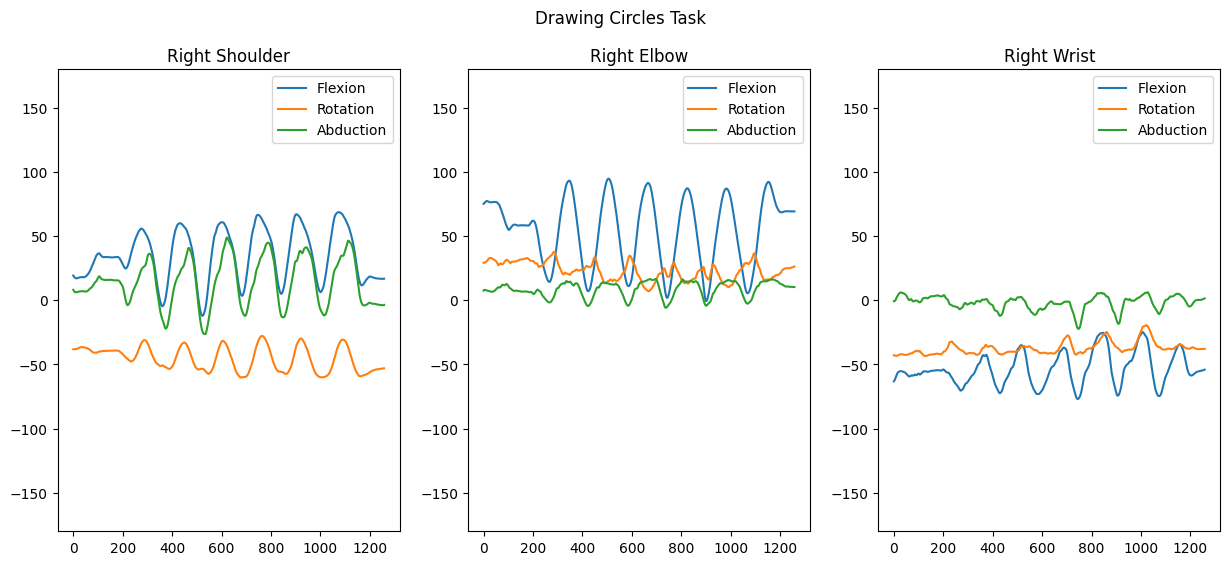

In [58]:
joints = ['Right Shoulder', 'Right Elbow', 'Right Wrist']

for task in range(len(Joint_Angles_dict)):
    fig, axList = plt.subplots(1,3, figsize=(15,6))
    fig.suptitle(joint_angles_euler[task]['Task Name'])
    
    # if task == 3:
    #     sequence = 'XYZ'
    # elif task == 5 or task == 6:
    #     sequence = 'ZYX'
    # else:
    #     sequence = 'ZXY'
    
    for j in range(len(joints)):
        joint = joints[j]
        axList[j].set_title(joint)
        axList[j].plot(joint_angles_euler[task][joint])
        axList[j].legend(['Flexion','Rotation', 'Abduction'])
        axList[j].set_ylim(-180, 180)

In [61]:
joint_angles_euler

{0: {'Task Name': 'Elbow Flexion Task',
  'Right Shoulder': array([[  7.94046551, -11.29992419,   0.50538102],
         [  7.92040205, -11.3537543 ,   0.2706824 ],
         [  7.89248046, -11.38169252,   0.05134019],
         ...,
         [  6.82760084, -12.08826502,   4.58554935],
         [  6.81792921, -12.00489508,   4.62621757],
         [  6.86256347, -11.90450248,   4.68740666]]),
  'Right Elbow': array([[14.15369351, 27.21249994, -5.31887035],
         [14.76280355, 27.25555833, -5.5263819 ],
         [15.38163955, 27.22982719, -5.7663535 ],
         ...,
         [ 4.06944955, 32.25263261, -3.90252608],
         [ 4.06455873, 32.23604637, -3.87441974],
         [ 4.05350859, 32.19373713, -3.84668908]]),
  'Right Wrist': array([[-20.59084374, -15.32779377,   0.66581238],
         [-21.02728053, -15.62215645,   0.58501032],
         [-21.44190199, -15.91773085,   0.52523125],
         ...,
         [-15.83615926,  -9.18644356,  -0.89975309],
         [-15.92553198,  -9.25830208